In [135]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn import preprocessing
from tensorflow.keras.models import load_model
%matplotlib inline

In [136]:
!git clone 'https://github.com/sachinkavindaa/Machine-learning-with-Python'

fatal: destination path 'Machine-learning-with-Python' already exists and is not an empty directory.


In [137]:
df = pd.read_csv('/content/Machine-learning-with-Python/ML/Diabetes/diabetes.csv')
df.head()

,Pregnancies,Glucose,Blood_Pressure,Skin_Thickness,Insulin,BMI,Diabetes_Pedigree_Function,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [138]:
df.describe()

,Pregnancies,Glucose,Blood_Pressure,Skin_Thickness,Insulin,BMI,Diabetes_Pedigree_Function,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [139]:
df_mod = df[(df.Blood_Pressure != 0) & (df.BMI != 0) & (df.Glucose != 0)]
print(df_mod.shape)

(724, 9)


In [140]:
def min_max_scaling(df_mod):
    
    df_norm = df_mod.copy()
    
    
    for column in df_norm.columns:
        df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
        
    return df_norm

df_scaled = min_max_scaling(df_mod)

In [141]:
feature_names = ['Pregnancies', 'Glucose', 'Blood_Pressure', 'Skin_Thickness', 'Insulin', 'BMI', 'Diabetes_Pedigree_Function', 'Age']
X = df_scaled[feature_names]
y = df_scaled.Outcome

In [142]:
from collections import Counter
target = df_mod['Outcome'].values
counter = Counter(target)
for k,v in counter.items():
	per = v / len(target) * 100
	print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=1, Count=249, Percentage=34.392%
Class=0, Count=475, Percentage=65.608%


In [147]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=3)

In [148]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [149]:
# determine the number of input features
n_features = X.shape[1]
# define model
model = Sequential()
model.add(Dense(5, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(3, kernel_initializer='he_normal', activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [150]:
# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['accuracy'])

In [151]:
# fit the model
history = model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=0, validation_data=(X_test,y_test))

In [152]:
# predict test set
yhat = model.predict(X_test)
pr = np.round(yhat)
# evaluate predictions
score = accuracy_score(y_test, pr)
print('Accuracy: %.3f' % score)

Accuracy: 0.768


In [153]:
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.786, Test: 0.768


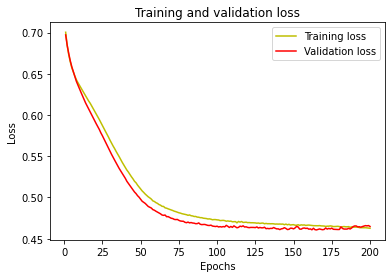

In [157]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

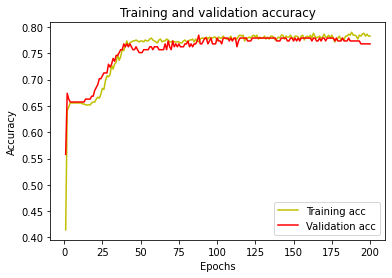

In [158]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [166]:
mythreshold= 0.34825
from sklearn.metrics import confusion_matrix

y_pred = (model.predict(X_test)>= mythreshold).astype(int)
cm=confusion_matrix(y_test, y_pred)  
print(cm)

[[91 28]
 [15 47]]


In [167]:
from sklearn.metrics import roc_curve
y_preds = model.predict(X_test).ravel()

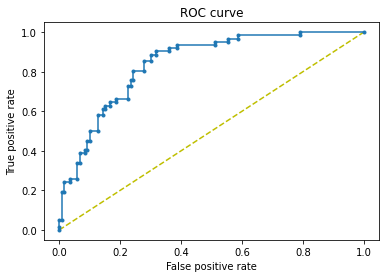

In [168]:
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [169]:
import pandas as pd
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 

Ideal threshold is:  33    0.34825
Name: thresholds, dtype: float32


In [170]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pr))

              precision    recall  f1-score   support

         0.0       0.81      0.85      0.83       119
         1.0       0.68      0.61      0.64        62

    accuracy                           0.77       181
   macro avg       0.74      0.73      0.74       181
weighted avg       0.76      0.77      0.76       181



In [171]:
from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

Area under curve, AUC =  0.8419625914882082


In [172]:
df_New=pd.DataFrame({'Actual':y_test, 'Predicted':y_preds})
df_New

,Actual,Predicted
57,0.0,0.288074
499,0.0,0.691844
174,0.0,0.042746
160,0.0,0.415370
489,0.0,0.904699
...,...,...
765,0.0,0.219034
555,0.0,0.296258
520,0.0,0.017257
600,0.0,0.074330
